# PYTHON VERSION

In [1]:
import sys
print(sys.version)

3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


# Rejection sampling in large dimensions.

Already knowing how to uniformly select a sample from a surface $D$ in the plane, the area of any disk can easily be calculated. This method can be extended in an obvious way to more dimensions. The idea is that if a point is randomly taken inside the cube with center 0 and edge length 2, then the probability of this point being inside the unit ball is 

$$p(d)=\frac{\omega(d)}{2^d}.$$

So if a large number $N$ of points is taken inside the cube, by the law of large numbers, the percentage of them that will "fall" into the ball is a good estimate of $p(d)$. This is exactly what the *vol* function defined in the routine below does.

In [2]:
from numpy import random

def vol(N,d):
    nhits = 0
    for i in range(N):
        x = random.uniform(-1,1,d)
        if sum(x ** 2) < 1: 
            nhits += 1
    return 2 ** d * nhits / N

d = 3
N = 10_000       
print ("The Monte Carlo estimate of ω(", d,") is  : %.5f " % vol (N,d))

The Monte Carlo estimate of ω( 3 ) is  : 4.22240 


The following function returns the volume of the unit ball in $d$ dimensions using the analytic formula: 
$$\omega(d) =\frac{\pi^{d/2}}{\Gamma\big(\frac{d}{2}+1\big)}$$ 

In [3]:
from math import gamma, pi 

def Vol1(d):
    x = d/2
    return pi ** x / gamma(x + 1)

print("The actual value of ω(", d,") is  : %.5f " % Vol1(d))

The actual value of ω( 3 ) is  : 4.18879 


#### Sampling with MCMC
The rejection method is not practical for sampling from a large-dimensional sphere. This problem can be solved using ideas from Markov Chain Monte Carlo (MCMC).

In particular, for a irreducible Markov chain with symmetric transition probabilities, the only invariant distribution is the uniform distribution in state space. Indeed, because the transition probabilities are symmetric the transition probability matrix will be doubly stochastic. Therefore, in order to randomly select a point from a space $D$, a Markovian chain that evolves in $D$ can be considered, with symmetric transition probabilities and enough steps for it to come close to its equilibrium state. 

One way to achieve this is as follows. Let $X_n= x\in D$. Displacement by $z$ where the step distribution $z$ is symmetric around 0 can have two outcomes. The fisrt outcome is making the move, if the point $x+z$ remains inside $D$, i.e. defining $X_{n+1}=x+z$. The second outcome is remaining in $x$, i.e. defining $X_{n+1}=x$. 

The following algorithm implements this idea to take 1,000 samples of a random variable with a uniform distribution on the unit disk

$$
D_2=\{(x,y)\in\mathbb{R}^2: x^2+y^2 < 1\}.
$$

The chain starts from zero and at each step tries a parallel shift to one of the axes, 
with a uniform distribution in `(-delta, +delta)`. 
If the displacement would drive the chain out of the disk, it is not realized and the chain remains in the position it was in at the previous time. The chain takes $N=100$ steps before sampling.

In [4]:
import random as r

delta = 1.0
N = 100 # number of steps to approach equilibrium
samples = 1000 
point_x = []
point_y = []

for _ in range(samples):
    x = [0,0]  ## start at the centre of th disc. This variable will keep the position of the chain
    R_sq = 0.0  ## this variable keeps the squared distance from 0. It saves some computations to keep it
    
    for _ in range(N):
        k = r.choice([0,1])  ## choose a jump direction at random
        z = r.uniform(-delta,delta) ## choose a jump size uniformly in (-delta,delta)
        x_prop_k = x[k] + z   ## propose a jump by z in the direction k
        R_sqprop = R_sq - x[k]**2+ x_prop_k**2 ## compute the squared distance from 0 after the proposed jump 
        if R_sqprop < 1.0: 
            R_sq = R_sqprop
            x[k]= x_prop_k   ## if the proposed jump leads to a point in the disc, then jump
   
    point_x.append(x[0])
    point_y.append(x[1])

Next up taking a sample from the cylinder:

$$
C_3=\{\,(x_1,x_2,x_3)\in\mathbb{R}^{3}:(x_1,x_2)\in D_2,\, |x_3| <1\}.
$$ 

This could be done by selecting $(x_1,x_2)$ uniformly on the disk $D_2$ and then the coordinate $x_3$ uniformly on (-1,+1). The probability that a randomly selected point from cylinder $C_3$ falls inside the ball $D_3=\{(x_1,x_2,x_3)\in\mathbb{R}^3: x_1^2+x_2^2+x_3^2<1\}$ is then 

$$ \frac{|D_3|}{|C_3|}= \frac{|D_3|}{2|D_2|}$$

since the volume of the cylinder $|C_2|$ is the base surface area ($|D_2||$) times its height (2). Using samples from cylinder $C_3$ and by counting how many of them fell into $D_2$ an estimation for the ratio $|D_3|/|D_2|$ can be done.

This procedure can be generalized to $d$ dimensions without problem. It is not difficult to modify the above algorithm to take random points in the $d$-dimensional unit ball

$$ D_d = \{(x_1,\ldots,x_{d})\in\mathbb{R}^{d}:\ x_1^2+\cdots+x_d^2 <1\}.$$ 

The chain by construction remains inside the $D_d$ ball, it is imprtant to let the chain take enough steps to get close to equilibrium. 
Then just by taking random points from the cylinder 

$$
C_{d+1}=\{\,(x_1,\ldots,x_{d+1})\in\mathbb{R}^{d+1}:(x_1,\ldots,x_d)\in D_d,\, |x_{d+1} | <1\}
$$

and by choosing their first $d$ coordinates uniformly in $D_d$ and the last one uniformly in (-1,1) the volume can be estimated.
The percentage of these points falling inside the ball $D_{d+1}$ can give us an estimate of the ratio $|D_{d+1}|/|D_d|$.

## Application 1

i) Write a routine that prints for dimensions $d=2,3,...$ the Monte Carlo estimated volume of the unit ball in $d$ dimensions, its actual value and the relative error of the estimate. Your routine should select $N=10^6$ points in the corresponding cube of each dimension, and should reach up to that dimension value where none of the $N$ selected points fell on the ball. 

ii) Plot the graph $d- \log p(d)$ for the theoretical value of the probability $p(d)$ (notice that the relative error of the estimate in (i) gets larger as the dimensions increase).

*In large dimensions, the fraction of the unit cube occupied by the ball inscribed in it is very small*. That is, in large dimensions, most of the points of the unit cube are located at its "corners". This is perhaps counter intuitive given the results from 2 and 3 dimensions.

In [5]:
# Application 1
# (i)
# Subroutine includes vol function, for the approximation of the volume of the unit sphere.

d = 2
N = 1000000  
while(vol(N,d)>0): # if vol(N,d)>0 then nhits=0
    print ("The Monte Carlo estimate of ω(", d,") is  : %.5f " % vol (N,d))
    print("The actual value of ω(", d,") is  : %.5f " % Vol1(d))
    print("The the realtive error for d = ", d," is  : %.5f " % (100*abs(1-vol(N,d)/Vol1(d))))
    d += 1

The Monte Carlo estimate of ω( 2 ) is  : 3.13885 
The actual value of ω( 2 ) is  : 3.14159 
The the realtive error for d =  2  is  : 0.00113 
The Monte Carlo estimate of ω( 3 ) is  : 4.18840 
The actual value of ω( 3 ) is  : 4.18879 
The the realtive error for d =  3  is  : 0.02277 
The Monte Carlo estimate of ω( 4 ) is  : 4.92619 
The actual value of ω( 4 ) is  : 4.93480 
The the realtive error for d =  4  is  : 0.15892 
The Monte Carlo estimate of ω( 5 ) is  : 5.26525 
The actual value of ω( 5 ) is  : 5.26379 
The the realtive error for d =  5  is  : 0.10614 
The Monte Carlo estimate of ω( 6 ) is  : 5.15430 
The actual value of ω( 6 ) is  : 5.16771 
The the realtive error for d =  6  is  : 0.36223 
The Monte Carlo estimate of ω( 7 ) is  : 4.77978 
The actual value of ω( 7 ) is  : 4.72477 
The the realtive error for d =  7  is  : 0.03585 
The Monte Carlo estimate of ω( 8 ) is  : 4.09907 
The actual value of ω( 8 ) is  : 4.05871 
The the realtive error for d =  8  is  : 0.87456 
The Mo

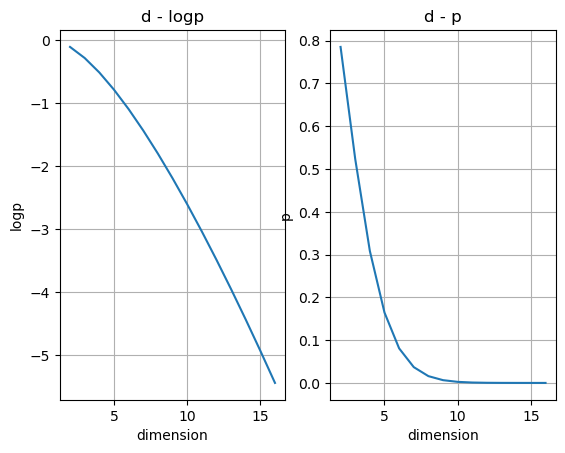

In [6]:
# (ii)
import matplotlib.pyplot as plt
import numpy as np
P = []
D = []
for d in range(2,17): # for d = 17 (dimension) nhits = 0 in the previous block of code
    p = Vol1(d)/2**d
    P.append(p)
    D.append(d)

logP = np.log10(P)

plt.subplot(1, 2, 1) 
plt.plot(D,logP)
plt.ylabel('logp')
plt.xlabel('dimension')
plt.title('d - logp')
plt.grid(True)  

plt.subplot(1, 2, 2) 
plt.plot(D,P)
plt.ylabel('p')
plt.xlabel('dimension')
plt.title('d - p')
plt.grid(True)  

## Application 2

(i) Construct a scatter plot showing the 1000 samples taken from disk $D_2$ with the above MCMC algorithm. Then do the same for delta = 0.01 and for delta = 20. Explain in a text cell why the resulting graph 'breaks down' when delta is "too small" or "too large"?

(ii) Write a routine that prints for dimensions $d=2,3,...,100$ the MCMC-estimated volume of the unit ball in $d$ dimensions, its true value and the relative error of the estimate. You can start from the obvious relation $|D_1|=2$ and work inductively to compute ω(2), ω(3),... etc.

In [7]:
# Application 2
###############################################################################################################
def mcmcplot(samples,delta):
    N = 100         ## number of steps to approach equilibrium
    point_x = []
    point_y = []

    for i in range(samples):
        x = [0,0]   ## start at the centre of th disc. This variable will keep the position of the chain
        R_sq = 0.0  ## this variable keeps the squared distance from 0. It saves some computations to keep it
        for j in range(N):
            k = r.choice([0,1])                    ## choose a jump direction at random
            z = r.uniform(-delta,delta)            ## choose a jump size uniformly in (-delta,delta)
            x_prop_k = x[k] + z                    ## propose a jump by z in the direction k
            R_sqprop = R_sq - x[k]**2+ x_prop_k**2 ## compute the squared distance from 0 after the proposed jump 
            if R_sqprop < 1.0: 
                R_sq = R_sqprop
                x[k]= x_prop_k                     ## if the proposed jump leads to a point in the disc, then jump
        point_x.append(x[0])
        point_y.append(x[1])
    ## Plotting code:
    fig, ax = plt.subplots()

    plt.scatter(point_x, point_y, color = 'green', s = 1) # parameter s determines the size of each dot in the scatter plot

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_aspect('equal')  # set aspect ratio 1:1

    plt.show()
###############################################################################################################

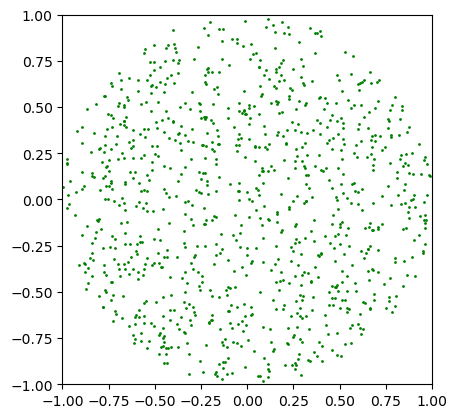

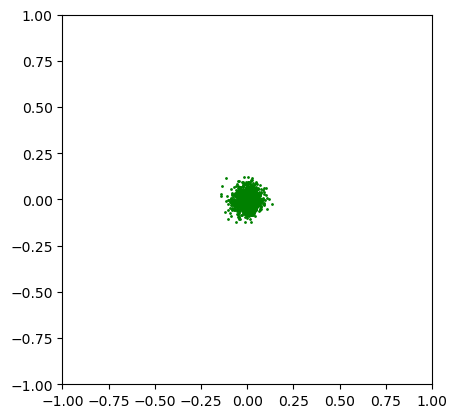

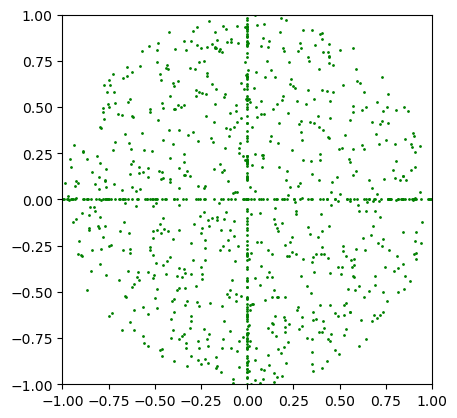

In [8]:
########################
samples = 1000
delta   = 1.0
mcmcplot(samples,delta)
########################
samples = 1000
delta   = 0.01
mcmcplot(samples,delta)
########################
samples = 1000
delta   = 20.0
mcmcplot(samples,delta)
########################

#### (i)

The graphs above have been plotted for `samples=1000` and for `delta=1.0, 0.01 & 20.0` respectively. Notice that for `delta=1.0` the points are distributed uniformly over the entire area of the unit disk, while for the other two values (`delta=0.01` and `delta=20.0`) the 1000 points (samples) show peculiar distributions within the same area. In particular, for `delta = 0.01`, the points are all concentrated near the beginning of the axes (0,0), which is due to the jumps z according to the formula: `z = r. uniform(-delta,delta)` and `x_prop_k = x[k] + z`, i.e. the variable z is a variable which takes values (randomly w.r.t the uniform distribution) within the interval (-0.01,0.01). Therefore, with such small jumps the points appear concentrated in a neighborhood of (0,0). As for the case where `delta = 20.0`, in the corresponding graph the experimental points show a preference on the `x=0` and `y=0` axes over the other points on the unit disk. That is, for large values of delta, the experimental points seem to cluster on the `x=0` and `y=0` axes, which may be due to the interval (-20.0,20.0) in which the variable z takes values. All the numbers within this interval have the same probability of being chosen according to the uniform distribution, in this case only the numbers that satisfy the condition: `R_sqprop < 1.0`, get accepted, where `R_sqprop` is the square of the distance of the (new) point after the jump z from the origin of the axes.

In [9]:
# (ii)
import numpy as np
import random 

###########################################################################################
def mcmc(samples,delta,d): ## d = dim
    N       = 100          ## number of steps to approach equilibrium
    nhits   = 0

    x = np.zeros(d)   ## start at the centre of the disc. This variable will keep the position of the chain
    R_sq = 0.0        ## this variable keeps the squared distance from 0. It saves some computations to keep it
    for i in range(samples):
        for j in range(N):
            k = random.randint(0,d-1)               ## choose a jump direction at random
            z = random.uniform(-delta,delta)        ## choose a jump size uniformly in (-delta,delta)
            x_prop_k = x[k] + z                     ## propose a jump by z in the direction k
            R_sqprop = R_sq - x[k]**2+ x_prop_k**2  ## compute the squared distance from 0 after the proposed jump 
            if(R_sqprop < 1.0): 
                R_sq = R_sqprop
                x[k]= x_prop_k                      ## if the proposed jump leads to a point in the disk, then jump
                nhits+=1                            ## checking if R_sqprop < 1.0 after equilibrium. 
    return(nhits/(N*samples))                       ## probability of the speciment to hit the untitary sphere of d-dimensions
###########################################################################################

In [10]:
for d in range(1,100):
    print("The probability of the speciment to hit the untitary sphere of d-dimensions = ", d, "is: ", mcmc(1000,1.0,d))

The probability of the speciment to hit the untitary sphere of d-dimensions =  1 is:  0.74762
The probability of the speciment to hit the untitary sphere of d-dimensions =  2 is:  0.68967
The probability of the speciment to hit the untitary sphere of d-dimensions =  3 is:  0.63873
The probability of the speciment to hit the untitary sphere of d-dimensions =  4 is:  0.6012
The probability of the speciment to hit the untitary sphere of d-dimensions =  5 is:  0.56751
The probability of the speciment to hit the untitary sphere of d-dimensions =  6 is:  0.53784
The probability of the speciment to hit the untitary sphere of d-dimensions =  7 is:  0.51779
The probability of the speciment to hit the untitary sphere of d-dimensions =  8 is:  0.49095
The probability of the speciment to hit the untitary sphere of d-dimensions =  9 is:  0.47811
The probability of the speciment to hit the untitary sphere of d-dimensions =  10 is:  0.46218
The probability of the speciment to hit the untitary sphere 